# Alcoholics Anonymous

Performing EEG analysis to detect the alcoholics!

More details regarding the dataset are available at https://archive.ics.uci.edu/ml/datasets/eeg+database


First do some magic to load the dataset!

In [2]:
import os
import requests
import tarfile

# Create a directory for the data
os.makedirs('data', exist_ok=True)

# Function to download a file from a URL
def download_file(url, save_path):
    response = requests.get(url, stream=True)
    with open(save_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)

# URLs for the datasets
train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/eeg-mld/SMNI_CMI_TRAIN.tar.gz"
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/eeg-mld/SMNI_CMI_TEST.tar.gz"

# File paths for saving the downloads
train_path = os.path.join('data', 'SMNI_CMI_TRAIN.tar.gz')
test_path = os.path.join('data', 'SMNI_CMI_TEST.tar.gz')

# Download the files
print("Downloading training dataset...")
download_file(train_url, train_path)
print("Downloading test dataset...")
download_file(test_url, test_path)

# Extract the tar.gz files
def extract_tar(file_path, extract_to):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=extract_to)

print("Extracting training dataset...")
extract_tar(train_path, 'data/train')
print("Extracting test dataset...")
extract_tar(test_path, 'data/test')

print("Download and extraction completed.")

Extracting training dataset...
Extracting test dataset...
Download and extraction completed.


Define the loading functions:


In [5]:
from os.path import isfile, isdir, join
from os import listdir
import gzip
import numpy as np
import pickle
from os.path import exists

def extract_data(train_path='data/train/SMNI_CMI_TRAIN', test_path='data/test/SMNI_CMI_TEST'):
    """
    Transforms the EEG dataset into the appropriate format
    :param train_path:
    :param test_path:
    :return:
    """

    def load_from_folder(path):
        files = [join(path, x) for x in listdir(path) if isfile(join(path, x)) and x[-3:] == '.gz']
        eeg_data = []
        for file_path in files:
            cfile = gzip.open(file_path, 'r')
            lines = cfile.readlines()
            cfile.close()
            data = lines[4:]
            data = [x for i, x in enumerate(data) if np.mod(i, 257) != 0]

            values = np.float32([float(x.split()[3]) for x in data]).reshape((64, 256))
            eeg_data.append(values)
        eeg_data = np.float32(eeg_data)
        return eeg_data

    print("Preprocessing the dataset...")
    data = []
    labels = []
    for folder in listdir(train_path):
        if isdir(join(train_path, folder)):
            data.append(load_from_folder(join(train_path, folder)))
            if folder[3] == 'a':
                labels.append(np.ones((data[-1].shape[0],)))
            else:
                labels.append(0 * np.ones((data[-1].shape[0],)))
    train_data = np.float32(np.concatenate(data))
    train_labels = np.float32(np.concatenate(labels))

    data = []
    labels = []
    for folder in listdir(test_path):
        if isdir(join(test_path, folder)):
            data.append(load_from_folder(join(test_path, folder)))
            if folder[3] == 'a':
                labels.append(np.ones((data[-1].shape[0],)))
            else:
                labels.append(0 * np.ones((data[-1].shape[0],)))
    test_data = np.float32(np.concatenate(data))
    test_labels = np.float32(np.concatenate(labels))

    with open('data/dataset.pickle', 'wb') as f:
        pickle.dump(train_data, f, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(train_labels, f, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(test_data, f, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(test_labels, f, protocol=pickle.HIGHEST_PROTOCOL)


def load_dataset():
    """
    Loads the EEG dataset
    :return:
    """

    if not exists('data/dataset.pickle'):
        extract_data()

    with open('data/dataset.pickle', 'rb') as f:
        train_data = pickle.load(f)
        train_labels = pickle.load(f)
        test_data = pickle.load(f)
        test_labels = pickle.load(f)

    return train_data, train_labels, test_data, test_labels

Now, we are ready to load the data!

In [6]:
X_train, y_train, X_test, y_test = load_dataset()

Preprocessing the dataset...


In [7]:
X_train = X_train.transpose((0, 2, 1))
X_test = X_test.transpose((0, 2, 1))

print(X_train.shape, X_test.shape)

(600, 256, 64) (600, 256, 64)


Let's visualize an EEG!

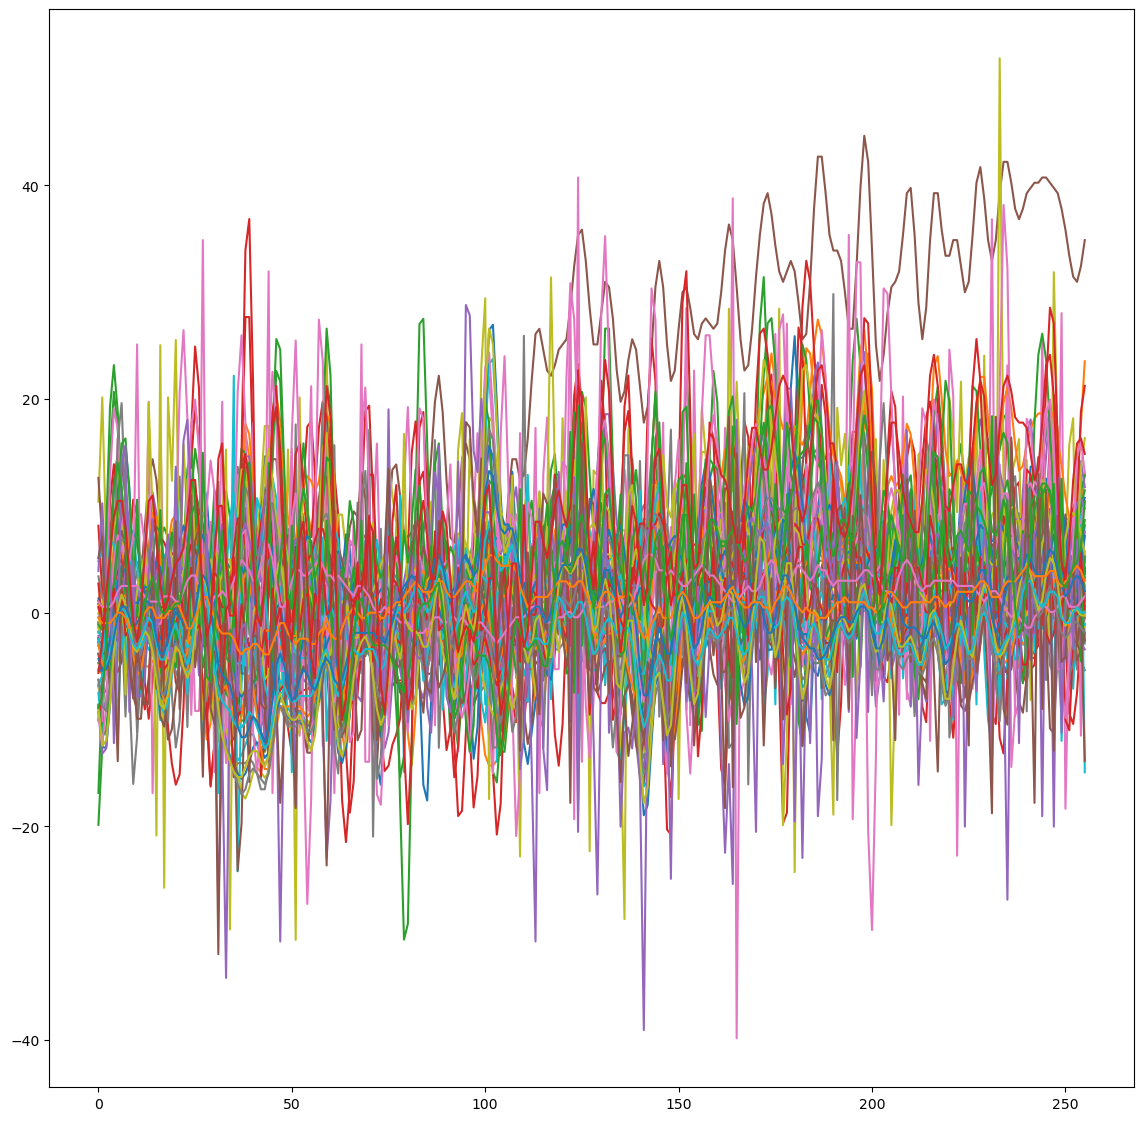

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(14, 14))
for i in range(64):
    plt.plot(X_train[0, :, i])


Standard scaling works quite well for this dataset!

In [9]:
from sklearn.preprocessing import StandardScaler

def scale_data(train_data, test_data):

    data = train_data.reshape((-1, train_data.shape[2]))
    scaler = StandardScaler()
    scaler.fit(data)

    # Scale the training data
    for i in range(train_data.shape[0]):
        train_data[i] = scaler.transform(train_data[i])

    # Scale the training data
    for i in range(test_data.shape[0]):
        test_data[i] = scaler.transform(test_data[i])

    return train_data, test_data


In [10]:
X_train, X_test = scale_data(X_train, X_test)

### MLP Classifer


Flatten the data first!

In [11]:
X_train_mlp = X_train.reshape((-1, 64 * 256))
X_test_mlp  = X_test.reshape((-1, 64 * 256))

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input
from keras.utils import to_categorical


model = Sequential()
model.add(Input(shape=(64 * 256,)))
model.add(Dense(512))
model.add(Activation('tanh'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_mlp, to_categorical(y_train), batch_size=32, epochs=30, verbose=0)
train_score, train_acc = model.evaluate(X_train_mlp, to_categorical(y_train), batch_size=32, verbose=0)
test_score, test_acc = model.evaluate(X_test_mlp, to_categorical(y_test), batch_size=32, verbose=0)
print ("Train acc, test acc = ", 100*train_acc, ", ", 100*test_acc)

Train acc, test acc =  99.6666669845581 ,  75.83333253860474


We can similarly use a recurrent model!

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical

# Adjust the input shape for LSTM
input_shape = (64, 256)

model = Sequential()
# Add an LSTM layer
model.add(Input(shape=input_shape))

model.add(LSTM(512, activation='tanh', return_sequences=False))
# Add the output layer
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Prepare the input data for LSTM
# Reshape X_train and X_test to (samples, 64, 256)
X_train_lstm = X_train_mlp.reshape((-1, 64, 256))
X_test_lstm = X_test_mlp.reshape((-1, 64, 256))

# Train the model
model.fit(X_train_lstm, to_categorical(y_train), batch_size=32, epochs=30, verbose=0)

# Evaluate the model
train_score, train_acc = model.evaluate(X_train_lstm, to_categorical(y_train), batch_size=32, verbose=0)
test_score, test_acc = model.evaluate(X_test_lstm, to_categorical(y_test), batch_size=32, verbose=0)

# Print results
print("Train acc, test acc = ", 100 * train_acc, ", ", 100 * test_acc)


Train acc, test acc =  100.0 ,  82.4999988079071


We can also use a GRU:

In [17]:
from tensorflow.keras.layers import GRU

# Adjust the input shape for LSTM
input_shape = (64, 256)

model = Sequential()
# Add an LSTM layer
model.add(Input(shape=input_shape))

model.add(GRU(512, activation='tanh', return_sequences=False))
# Add the output layer
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Prepare the input data for LSTM
# Reshape X_train and X_test to (samples, 64, 256)
X_train_lstm = X_train_mlp.reshape((-1, 64, 256))
X_test_lstm = X_test_mlp.reshape((-1, 64, 256))

# Train the model
model.fit(X_train_lstm, to_categorical(y_train), batch_size=32, epochs=30, verbose=0)

# Evaluate the model
train_score, train_acc = model.evaluate(X_train_lstm, to_categorical(y_train), batch_size=32, verbose=0)
test_score, test_acc = model.evaluate(X_test_lstm, to_categorical(y_test), batch_size=32, verbose=0)

# Print results
print("Train acc, test acc = ", 100 * train_acc, ", ", 100 * test_acc)


Train acc, test acc =  100.0 ,  83.33333134651184


### Something quite simple, but smart!


We are looking for certain patterns in the input signal. We can use a "Bag-of-Features" approach to quantize the data and then build a histogram.

In [21]:
from keras.layers import Conv1D, GlobalAveragePooling1D

model = Sequential()

# Quantize the input features (BoF-like)
model.add(Input(shape=(256, 64)))
model.add(Conv1D(32, 1))
model.add(Activation('softmax'))
model.add(GlobalAveragePooling1D())

model.add(Dense(512))
model.add(Activation('tanh'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, to_categorical(y_train), batch_size=32, epochs=30, verbose=0)
train_score, train_acc = model.evaluate(X_train, to_categorical(y_train), batch_size=32, verbose=0)
test_score, test_acc = model.evaluate(X_test, to_categorical(y_test), batch_size=32, verbose=0)
print ("Train acc, test acc = ", 100*train_acc, ", ", 100*test_acc)

Train acc, test acc =  95.99999785423279 ,  84.6666693687439
